# 1. 전처리 및 데이터 준비

In [91]:
import numpy as np
import pandas as pd   
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import xgboost as xgb
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# -------------------------
# 데이터 로드
# -------------------------
df = pd.read_csv('univ355.csv')

# -------------------------
# 결측치 컬럼 제거
# -------------------------
drop_missing_cols = [
    'why_not_rechoice', 'future_job_desc', 'income_class', 'income_contest',
    'income_perf', 'income_broadcast', 'income_studio', 'income_creator',
    'income_choreo', 'info_dept', 'info_career_center', 'info_online',
    'info_family', 'info_friends', 'info_academy', 'info_self',
    'help_financial', 'help_resume', 'help_career', 'help_social',
    'help_no', 'non_stay_reason', 'total_univ'
]
df = df.drop(columns=drop_missing_cols, errors='ignore')

# -------------------------
# current_area 관련 변수 제거
# -------------------------
current_area_cols = [col for col in df.columns if col.startswith('current_area')]
df = df.drop(columns=current_area_cols, errors='ignore')

# -------------------------
# 오타 수정
# -------------------------
if 'birth_area' in df.columns:
    df['birth_area'] = df['birth_area'].replace({'g': 'gangwon'})  # 'g' -> 'gangwon'

# -------------------------
# 범주형 변수 매핑 및 원-핫 인코딩
# -------------------------
# dance_years 매핑
midpoint_map = {'less2':1, '2to4':2, '4to7':3, '7to10':4, 'over10':5}
if 'dance_years' in df.columns:
    df['dance_years'] = df['dance_years'].map(midpoint_map)

# 원-핫 인코딩
columns_to_encode = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]
df = pd.get_dummies(df, columns=columns_to_encode, drop_first=False, dtype=float)

# -------------------------
# 분석 제외 변수 제거
# -------------------------
remove_vars = ["prof_hi", "int_major", "enter_year"]
df = df.drop(columns=remove_vars, errors='ignore')

# -------------------------
# 상관계수 높은 변수 사전 삭제 (전처리 단계)
# -------------------------
high_corr_remove = ['lecture_qual', 'peer_personal', 'enjoy_major', 'prof_chat','peer_study']
df = df.drop(columns=high_corr_remove, errors='ignore')


# -------------------------
# sat 변수 생성 및 이진 분류
# -------------------------
sat_cols = ['univ_proud', 'univ_belong', 'major_proud', 'major_belong']
df['sat'] = df[sat_cols].mean(axis=1)
sat_median = df['sat'].median()
df['sat_group'] = (df['sat'] >= sat_median).astype(int)

# -------------------------
# 설명용 출력
# -------------------------
print("✅ 최종 데이터셋 컬럼 수:", df.shape[1])
print("sat 중위수:", sat_median)
print(df[['sat', 'sat_group']].head())


✅ 최종 데이터셋 컬럼 수: 178
sat 중위수: 4.0
    sat  sat_group
0  4.00          1
1  4.50          1
2  3.00          0
3  3.00          0
4  4.75          1


In [94]:
import pandas as pd
from scipy.stats import skew, kurtosis, ttest_ind

# 0/1 집단 분리
group1 = df[df['sat_group'] == 1]['sat']
group0 = df[df['sat_group'] == 0]['sat']

# 요약 통계 계산
summary = {
    "group": ["전체", "0집단", "1집단"],
    "n": [df['sat'].count(), group0.count(), group1.count()],
    "mean": [df['sat'].mean(), group0.mean(), group1.mean()],
    "std": [df['sat'].std(), group0.std(), group1.std()],
    "skew": [skew(df['sat']), skew(group0), skew(group1)],
    "kurtosis": [kurtosis(df['sat']), kurtosis(group0), kurtosis(group1)]
}

summary_df = pd.DataFrame(summary).round(3)

# t-test (독립표본)
t_stat, p_val = ttest_ind(group1, group0, equal_var=False)  # Welch’s t-test (이분산 가정)

print("=== sat 요약 통계 ===")
print(summary_df)
print("\n=== 집단 간 T-검정 결과 ===")
print(f"t = {t_stat:.3f}, p = {p_val:.4f}")


=== sat 요약 통계 ===
  group    n   mean    std   skew  kurtosis
0    전체  355  3.887  0.944 -0.774     0.489
1   0집단  140  2.941  0.680 -1.434     1.807
2   1집단  215  4.502  0.456  0.019    -1.828

=== 집단 간 T-검정 결과 ===
t = 23.903, p = 0.0000


# 2 변수 선택 + RFECV / ElasticNet 파이프라인

In [2]:
# ======================================
# ✅ 파이프라인 기반: ElasticNet + RFECV(LR/DT/RF/XGB)
#    - 변수선택은 항상 훈련 데이터(=X_train) 내부에서만 수행
#    - 폴드별 선택 변수 -> 교집합(안정적 변수) 추출
#    - CV(파이프라인 전체) & Hold-out 평가
# ======================================

import numpy as np
import pandas as pd
from itertools import combinations
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                             roc_auc_score)
import warnings
warnings.filterwarnings("ignore")

# ------------- 설정 -------------
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# (사용자 환경에 이미 df, X, y, X_train, X_test... 이 있다면 아래에서 재정의하지 않음.
#  없으면 간단하게 재생성 — 여기에선 df가 이미 전처리 끝났다는 전제)
try:
    df  # if df exists, do nothing
except NameError:
    raise RuntimeError("데이터프레임 df가 존재하지 않습니다. 먼저 전처리 셀을 실행하세요.")

# 타깃/설명변수 설정 (기존 전처리 셀에서 이미 만들어두었다면 동일하게 사용)
target_col = 'sat_group'
drop_cols = ['id','univ_proud','univ_belong','major_proud','major_belong','sat','sat_group']
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')
y = df[target_col].copy()

# 학습/테스트 분할 (이 분할에서 X_train에 대해서만 변수선택이 일어나도록 설계)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# CV fold 설정
inner_cv_n_splits = 5   # RFECV 내부/ENet 내부용 (if needed)
outer_cv_n_splits = 5   # cross_validate (파이프라인 전체의 CV)
inner_cv = StratifiedKFold(n_splits=inner_cv_n_splits, shuffle=True, random_state=RANDOM_STATE)
outer_cv = StratifiedKFold(n_splits=outer_cv_n_splits, shuffle=True, random_state=RANDOM_STATE)

# 성능 지표 (cross_validate에서 사용)
scoring = {"accuracy": "accuracy", "f1": "f1", "roc_auc": "roc_auc"}

# ------------- 파이프라인 정의 -------------
# NOTE:
# - RFECV 내부에서 추가적인 CV가 돌아가므로 RFECV의 n_jobs는 1로 설정하여
#   중첩 병렬(nested parallel)로 인한 오류/충돌을 피합니다.
# - 전체 cross_validate에서 n_jobs=-1로 병렬 처리를 하도록 하면 fold 간 병렬화가 이루어짐.

# ElasticNet: Pipeline (StandardScaler -> LogisticRegressionCV)
enet_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("clf", LogisticRegressionCV(
        Cs=10, cv=inner_cv, penalty="elasticnet", solver="saga",
        l1_ratios=[.1, .3, .5, .7, .9],   # <-- 탐색 범위 확장
        scoring="f1", max_iter=5000,
        random_state=RANDOM_STATE, n_jobs=-1
    ))
])


# RFECV pipelines: estimator inside RFECV + final classifier (same type)
# Use n_jobs=1 inside RFECV to avoid nested parallel issues.
def make_rfecv_pipeline(base_estimator, final_estimator=None, name="est"):
    if final_estimator is None:
        final_estimator = base_estimator
    rfecv = RFECV(
        estimator=base_estimator,
        step=1,
        cv=inner_cv,
        scoring='f1',
        min_features_to_select=max(1, int(0.05 * X_train.shape[1])),  # <-- 동적 설정
        n_jobs=-1,
        verbose=0
    )
    return Pipeline([("feature_selection", rfecv), ("clf", final_estimator)])

rfecv_lr_pipeline = make_rfecv_pipeline(LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                        LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
                                        name='LR')

rfecv_dt_pipeline = make_rfecv_pipeline(DecisionTreeClassifier(random_state=RANDOM_STATE),
                                        DecisionTreeClassifier(random_state=RANDOM_STATE),
                                        name='DT')

rfecv_rf_pipeline = make_rfecv_pipeline(RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                        RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
                                        name='RF')

rfecv_xgb_pipeline = make_rfecv_pipeline(XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                         XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=-1),
                                         name='XGB')

models = {
    "ElasticNet": enet_pipeline,
    "RFECV_LR": rfecv_lr_pipeline,
    "RFECV_DT": rfecv_dt_pipeline,
    "RFECV_RF": rfecv_rf_pipeline,
    "RFECV_XGB": rfecv_xgb_pipeline
}

# ------------- 폴드별 선택 변수 추출 (X_train 내부에서만 수행) -------------
print(">>> 폴드별 선택 변수(각 모델) 계산 (주의: RFECV는 시간이 오래 걸릴 수 있음) ...")
selected_per_model = {}   # model_name -> list of sets (len = outer_cv_n_splits)

for name, pipe in models.items():
    fold_sets = []
    for fold_idx, (tr_idx, val_idx) in enumerate(outer_cv.split(X_train, y_train)):
        X_tr_fold = X_train.iloc[tr_idx]
        y_tr_fold = y_train.iloc[tr_idx]

        if name == "ElasticNet":
            # ElasticNet: fit LogisticRegressionCV on train-fold, take non-zero coefs
            enet_fold = LogisticRegressionCV(
                Cs=10,
                cv=inner_cv,
                penalty="elasticnet",
                solver="saga",
                l1_ratios=[.1, .3, .5, .7, .9],
                scoring="f1",
                max_iter=5000,
                random_state=RANDOM_STATE,
                n_jobs=-1
            )
            enet_fold.fit(X_tr_fold, y_tr_fold)
            coefs = enet_fold.coef_.ravel()
            sel = set(X_tr_fold.columns[coefs != 0])

        else:
            # For RFECV models: instantiate a fresh RFECV estimator with same base estimator
            if name == "RFECV_LR":
                base = LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE)
            elif name == "RFECV_DT":
                base = DecisionTreeClassifier(random_state=RANDOM_STATE)
            elif name == "RFECV_RF":
                base = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
            elif name == "RFECV_XGB":
                base = XGBClassifier(n_estimators=200, random_state=RANDOM_STATE, eval_metric='logloss', n_jobs=-1)
            else:
                raise ValueError(name)

            rfecv_fold = RFECV(
                estimator=base,
                step=1,
                cv=inner_cv,
                scoring='f1',
                min_features_to_select=max(1, int(0.05 * X_train.shape[1])),
                n_jobs=1
            )
            rfecv_fold.fit(X_tr_fold, y_tr_fold)
            sel = set(X_tr_fold.columns[rfecv_fold.support_])

        fold_sets.append(sel)

    selected_per_model[name] = fold_sets
    # print a quick summary
    intersec = set.intersection(*fold_sets) if len(fold_sets) > 0 else set()
    print(f" - {name}: fold별 선택 수 = {[len(s) for s in fold_sets]}, 교집합(안정적) 수 = {len(intersec)}")

# ------------- Jaccard 안정성 지수 계산 함수 -------------
def mean_pairwise_jaccard(list_of_sets):
    if len(list_of_sets) < 2:
        return np.nan
    pairs = list(combinations(range(len(list_of_sets)), 2))
    scores = []
    for i, j in pairs:
        a, b = list_of_sets[i], list_of_sets[j]
        if len(a | b) == 0:
            scores.append(1.0)
        else:
            scores.append(len(a & b) / len(a | b))
    return np.mean(scores)

# ------------- 교차검증(CV, 파이프라인 전체) 및 홀드아웃 평가 -------------
results = []
for name, pipe in models.items():
    print(f"\n===== 평가 중: {name} =====")
    # 1) CV on training set (파이프라인 전체; pipe 내부에서 selection이 일어남)
    # cross_validate returns arrays for test_accuracy/test_f1/test_roc_auc
    cv_res = cross_validate(pipe, X_train, y_train, cv=outer_cv, scoring=scoring, n_jobs=-1, error_score=np.nan)
    cv_mean = {metric: np.nanmean(cv_res[f"test_{metric}"]) for metric in scoring.keys()}
    cv_std = {metric: np.nanstd(cv_res[f"test_{metric}"]) for metric in scoring.keys()}

    # 2) Hold-out: fit pipeline on full X_train, evaluate on X_test
    # (파이프라인 내부에서 feature selection이 훈련 데이터 전체에서 수행되고, 그 결과로 최종 classifier 학습)
    fitted_pipe = pipe.fit(X_train, y_train)  # 안전: selection happens only on X_train
    # preds
    y_pred = fitted_pipe.predict(X_test)
    # probability/score for ROC-AUC
    y_score = None
    try:
        y_score = fitted_pipe.predict_proba(X_test)[:, 1]
    except Exception:
        try:
            y_score = fitted_pipe.decision_function(X_test)
        except Exception:
            y_score = None

    holdout_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    # 3) fold-wise selected sets and Jaccard
    fold_sets = selected_per_model[name]
    jacc = mean_pairwise_jaccard(fold_sets)
    stable_vars = set.intersection(*fold_sets) if len(fold_sets) > 0 else set()

    # 4) also get final selected vars from the pipeline (if RFECV present)
    final_selected = []
    if "feature_selection" in fitted_pipe.named_steps:
        try:
            mask = fitted_pipe.named_steps['feature_selection'].support_
            final_selected = list(X_train.columns[mask])
        except Exception:
            final_selected = []
    else:
        # ElasticNet: read non-zero coefs from final classifier
        if name == "ElasticNet":
            try:
                coef = fitted_pipe.named_steps['clf'].coef_.ravel()
                final_selected = list(X_train.columns[coef != 0])
            except Exception:
                final_selected = []

    results.append({
        "model": name,
        "cv_mean": cv_mean,
        "cv_std": cv_std,
        "holdout": holdout_metrics,
        "jaccard": jacc,
        "stable_vars": sorted(list(stable_vars)),
        "final_selected": sorted(final_selected)
    })

# ------------- 결과 출력 (정리된 표 형식) -------------
# Build a summary dataframe
summary_rows = []
for r in results:
    summary_rows.append({
        "model": r["model"],
        "n_stable_vars": len(r["stable_vars"]),
        "stable_vars": ", ".join(r["stable_vars"]),
        "CV_f1_mean": r["cv_mean"]["f1"],
        "CV_acc_mean": r["cv_mean"]["accuracy"],
        "CV_roc_mean": r["cv_mean"]["roc_auc"],
        "Holdout_f1": r["holdout"]["f1"],
        "Holdout_acc": r["holdout"]["accuracy"],
        "Holdout_roc": r["holdout"]["roc_auc"],
        "Jaccard": r["jaccard"]
    })

summary_df = pd.DataFrame(summary_rows).sort_values(by="CV_f1_mean", ascending=False)
print("\n\n=== 요약 표 ===")
display(summary_df)

# 상세: 안정적 변수 / 최종 선택변수 전체 출력
for r in results:
    print(f"\n--- {r['model']} ---")
    print(f"폴드 교집합(안정적) 변수 수: {len(r['stable_vars'])}")
    if len(r['stable_vars']) > 0:
        print("안정적 변수 (알파벳순):")
        print(", ".join(r['stable_vars']))
    else:
        print("안정적 변수: 없음")

    print(f"\n파이프라인(전체 X_train 기반)에서 최종 선택된 변수 수: {len(r['final_selected'])}")
    if len(r['final_selected']) > 0:
        print("최종 선택 변수 (알파벳순):")
        print(", ".join(r['final_selected']))


>>> 폴드별 선택 변수(각 모델) 계산 (주의: RFECV는 시간이 오래 걸릴 수 있음) ...
 - ElasticNet: fold별 선택 수 = [30, 30, 62, 63, 24], 교집합(안정적) 수 = 17
 - RFECV_LR: fold별 선택 수 = [20, 72, 114, 54, 41], 교집합(안정적) 수 = 9
 - RFECV_DT: fold별 선택 수 = [70, 8, 48, 109, 98], 교집합(안정적) 수 = 1
 - RFECV_RF: fold별 선택 수 = [93, 119, 79, 113, 150], 교집합(안정적) 수 = 75
 - RFECV_XGB: fold별 선택 수 = [50, 76, 49, 41, 25], 교집합(안정적) 수 = 8

===== 평가 중: ElasticNet =====

===== 평가 중: RFECV_LR =====

===== 평가 중: RFECV_DT =====

===== 평가 중: RFECV_RF =====

===== 평가 중: RFECV_XGB =====


=== 요약 표 ===


,model,n_stable_vars,stable_vars,CV_f1_mean,CV_acc_mean,CV_roc_mean,Holdout_f1,Holdout_acc,Holdout_roc,Jaccard
4,RFECV_XGB,8,"course_variety, peer_external, prof_access, pr...",0.877796,0.850877,0.898052,0.847059,0.816901,0.875415,0.338712
0,ElasticNet,17,"course_variety, know_reason, move_univ, peer_a...",0.865948,0.831140,0.896339,0.873563,0.845070,0.858804,0.471099
3,RFECV_RF,75,"admin_serv, ask_q, burnout, car_spt, change_ca...",0.831169,0.771930,0.833766,0.876404,0.845070,0.882060,0.733540
1,RFECV_LR,9,"course_variety, edu_doubt, exp_video, has_inco...",0.815991,0.779449,0.865183,0.764045,0.704225,0.734219,0.308191
2,RFECV_DT,1,go_grad,0.728233,0.679637,0.668439,0.795181,0.760563,0.758721,0.310108



--- ElasticNet ---
폴드 교집합(안정적) 변수 수: 17
안정적 변수 (알파벳순):
course_variety, know_reason, move_univ, peer_advice, peer_event, peer_external, prof_access, prof_event, prof_passion, student_interact, students_diligent, study_hard, support_fac, theory_cls, time_eff, try_hard, work_fee

파이프라인(전체 X_train 기반)에서 최종 선택된 변수 수: 89
최종 선택 변수 (알파벳순):
abroad_practice, admin_serv, birth_area_chungcheong, birth_area_gangwon, birth_area_seoul, burnout, career_course, change_career, change_major, course_variety, drink_freq, drop_out, edu_doubt, enter_type_transfer, exercise_reg, exp_concours, exp_video, field_practice, fit_major, gender, go_grad, has_income, housing_edu, housing_green, housing_infra, housing_neighbor, housing_type_independent, housing_type_parents, job_prep, job_region_honam, job_region_yeongnam, job_test, know_reason, learn_fun, major_detail_jazzdance, major_detail_sportsdance, major_detail_streetdance, major_factor_on_interest, major_factor_total, major_rank, move_univ, peer_advice, peer_c

# 3 안정적 변수 기반 최종 모델링

In [3]:
# ======================================
# ✅ 안정적 변수 기반 모델링 (LogReg, DT, RF, XGB)
# ======================================

from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef

final_models = {
    "LogReg": LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE),
    "DT": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "RF": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1),
    "XGB": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,
                         use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
}

stable_vars_dict = {r["model"]: r["stable_vars"] for r in results}
results_final = []

for source, stable_vars in stable_vars_dict.items():
    if len(stable_vars) == 0:
        print(f">>> {source}: 안정적 변수 없음 → 스킵")
        results_final.append({
            "source": source, "model": None, "n_features": 0
        })
        continue

    print(f"\n>>> {source}: 안정적 변수 {len(stable_vars)}개로 모델링")

    for m_name, clf in final_models.items():
        # 조건부 스케일링
        if m_name == "LogReg":
            pipe = Pipeline([("scaler", StandardScaler()), ("clf", clf)])
        else:
            pipe = Pipeline([("clf", clf)])

        # 5-fold CV
        cv_res = cross_validate(pipe, X_train[stable_vars], y_train,
                                cv=outer_cv, scoring=scoring, n_jobs=-1)
        cv_mean = {m: np.mean(cv_res[f"test_{m}"]) for m in scoring}
        cv_std = {m: np.std(cv_res[f"test_{m}"]) for m in scoring}

        # Holdout
        pipe.fit(X_train[stable_vars], y_train)
        y_pred = pipe.predict(X_test[stable_vars])
        try:
            y_score = pipe.predict_proba(X_test[stable_vars])[:, 1]
        except:
            y_score = pipe.decision_function(X_test[stable_vars])

        holdout = {
            "accuracy": accuracy_score(y_test, y_pred),
            "balanced_acc": balanced_accuracy_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred),
            "precision": precision_score(y_test, y_pred, zero_division=0),
            "recall": recall_score(y_test, y_pred),
            "roc_auc": roc_auc_score(y_test, y_score),
            "mcc": matthews_corrcoef(y_test, y_pred)
        }

        results_final.append({
            "source": source,
            "model": m_name,
            "n_features": len(stable_vars),
            **{f"CV_{k}_mean": v for k, v in cv_mean.items()},
            **{f"CV_{k}_std": cv_std[k] for k in scoring},
            **{f"Test_{k}": v for k, v in holdout.items()}
        })
from sklearn.metrics import precision_recall_curve
# proba는 모델·파이프 따라 다를 수 있음
# 훈련 세트 점수
y_score_tr = pipe.predict_proba(X_train[stable_vars])[:, 1]
prec, rec, thr = precision_recall_curve(y_train, y_score_tr)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
best_thr = thr[f1s[:-1].argmax()] if len(thr) else 0.5

# 테스트에서 적용
y_score_te = pipe.predict_proba(X_test[stable_vars])[:, 1]
y_pred_te = (y_score_te >= best_thr).astype(int)

# 요약 테이블
results_final_df = pd.DataFrame(results_final)
print("\n\n=== 안정적 변수 기반 최종 성능표 ===")
display(results_final_df.sort_values(by="CV_f1_mean", ascending=False))


>>> ElasticNet: 안정적 변수 17개로 모델링

>>> RFECV_LR: 안정적 변수 9개로 모델링

>>> RFECV_DT: 안정적 변수 1개로 모델링

>>> RFECV_RF: 안정적 변수 75개로 모델링

>>> RFECV_XGB: 안정적 변수 8개로 모델링


=== 안정적 변수 기반 최종 성능표 ===


,source,model,n_features,CV_accuracy_mean,CV_f1_mean,CV_roc_auc_mean,CV_accuracy_std,CV_f1_std,CV_roc_auc_std,Test_accuracy,Test_balanced_acc,Test_f1,Test_precision,Test_recall,Test_roc_auc,Test_mcc
16,RFECV_XGB,LogReg,8,0.834586,0.863775,0.907721,0.039085,0.032817,0.033630,0.774648,0.782807,0.800000,0.864865,0.744186,0.827243,0.553342
14,RFECV_RF,RF,75,0.820363,0.856082,0.894556,0.036078,0.030537,0.043564,0.845070,0.834718,0.873563,0.863636,0.883721,0.876661,0.673928
15,RFECV_RF,XGB,75,0.820238,0.855872,0.870012,0.053296,0.041635,0.054457,0.845070,0.840947,0.870588,0.880952,0.860465,0.901993,0.677963
2,ElasticNet,RF,17,0.816855,0.851804,0.901064,0.049290,0.041428,0.043440,0.788732,0.781977,0.823529,0.833333,0.813953,0.893688,0.560703
3,ElasticNet,XGB,17,0.820489,0.850968,0.889023,0.041838,0.038636,0.028696,0.746479,0.747093,0.780488,0.820513,0.744186,0.877907,0.485396
0,ElasticNet,LogReg,17,0.820551,0.850605,0.902116,0.049738,0.047106,0.042281,0.774648,0.776578,0.804878,0.846154,0.767442,0.874585,0.543317
4,RFECV_LR,LogReg,9,0.802820,0.838561,0.879280,0.013016,0.014971,0.026900,0.732394,0.710548,0.786517,0.760870,0.813953,0.801910,0.430870
18,RFECV_XGB,RF,8,0.785150,0.827530,0.872300,0.047863,0.036620,0.042371,0.788732,0.775748,0.827586,0.818182,0.837209,0.858804,0.555196
19,RFECV_XGB,XGB,8,0.778008,0.817582,0.856136,0.038869,0.029794,0.037210,0.788732,0.775748,0.827586,0.818182,0.837209,0.850498,0.555196
12,RFECV_RF,LogReg,75,0.774875,0.812991,0.851822,0.051806,0.046422,0.040610,0.788732,0.800664,0.810127,0.888889,0.744186,0.843854,0.587814


# 4. 상위 5개 모델 상세 성능

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def safe_columns(df, cols):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        print("빠진 컬럼:", missing)
    return [c for c in cols if c in df.columns]

# -------------------------
# CV상위 5개 모델 상세 성능
# -------------------------
top_models = {
    "RFECV_XGB+LogReg": {
        "vars": ['course_variety', 'peer_external', 'prof_access', 'prof_passion',
                 'student_interact', 'theory_cls', 'time_eff', 'univ_factor_prefer_prof'], 
        "model":  LogisticRegression(max_iter=1000, solver='liblinear', random_state=RANDOM_STATE, n_jobs=-1)
    },

    "RFECV_RF+RF": {
        "vars": ['admin_serv', 'ask_q', 'burnout', 'car_spt', 'change_career', 'change_major', 'cont_major', 
        'course_variety', 'dance_years', 'drink_freq', 'drop_out', 'edu_doubt', 'exercise_reg', 'exp_group_comp',
        'exp_solo_comp', 'find_data', 'fit_major', 'get_fdbk', 'go_abroad', 'go_grad', 'grade', 'housing_culture',
        'housing_edu', 'housing_green', 'housing_hygiene', 'housing_infra', 'housing_neighbor', 'housing_safety',
        'housing_transit', 'intern_abroad', 'know_reason', 'learn_fun', 'lecture_fac', 'mental_health', 'move_univ',
        'peer_advice', 'peer_career', 'peer_class', 'peer_event', 'peer_external', 'physical_health', 'prac_cls',
        'prof_access', 'prof_career', 'prof_class_talk', 'prof_effort', 'prof_event', 'prof_exp', 'prof_grade',
        'prof_other_talk', 'prof_passion', 'prof_personal', 'real_appl', 'scholarship', 'self_study', 'smoke_exp', 
        'stay_after', 'student_interact', 'students_diligent', 'study_hard', 'study_mate', 'support_fac', 'take_leave', 
        'theory_cls', 'time_eff', 'transport', 'try_fail', 'try_hard', 'tuition', 'univ_course_year', 'univ_factor_prefer_prof', 
        'univ_name_jau', 'univ_rank', 'work_fee', 'write_vol'

        ],
        "model": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    },

     "RFECV_RF+XGB": {
        "vars": [  'admin_serv', 'ask_q', 'burnout', 'car_spt', 'change_career', 'change_major', 'cont_major',
        'course_variety', 'dance_years', 'drink_freq', 'drop_out', 'edu_doubt', 'exercise_reg', 'exp_group_comp',
        'exp_solo_comp', 'find_data', 'fit_major', 'get_fdbk', 'go_abroad', 'go_grad', 'grade', 'housing_culture',
        'housing_edu', 'housing_green', 'housing_hygiene', 'housing_infra', 'housing_neighbor', 'housing_safety',
        'housing_transit', 'intern_abroad', 'know_reason', 'learn_fun', 'lecture_fac', 'mental_health', 'move_univ',
        'peer_advice', 'peer_career', 'peer_class', 'peer_event', 'peer_external', 'physical_health', 'prac_cls',
        'prof_access', 'prof_career', 'prof_class_talk', 'prof_effort', 'prof_event', 'prof_exp', 'prof_grade', 
        'prof_other_talk', 'prof_passion', 'prof_personal', 'real_appl', 'scholarship', 'self_study', 'smoke_exp', 
        'stay_after', 'student_interact', 'students_diligent', 'study_hard', 'study_mate', 'support_fac', 'take_leave',
        'theory_cls', 'time_eff', 'transport', 'try_fail', 'try_hard', 'tuition', 'univ_course_year', 'univ_factor_prefer_prof',
        'univ_name_jau', 'univ_rank', 'work_fee', 'write_vol'
],  
        "model": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,eval_metric='logloss', n_jobs=-1)
     },

    "ElasticNet+RF": {
        "vars": ['course_variety', 'know_reason', 'move_univ', 'peer_advice',
         'peer_event', 'peer_external','prof_access', 'prof_event', 'prof_passion', 'student_interact',
         'students_diligent','study_hard', 'support_fac', 'theory_cls', 'time_eff', 'try_hard', 'work_fee'
], 
        "model": RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
    }, 
   
     "ElasticNet+XGB": {
        "vars": ['course_variety', 'know_reason', 'move_univ', 'peer_advice',
         'peer_event', 'peer_external','prof_access', 'prof_event', 'prof_passion', 'student_interact',
         'students_diligent','study_hard', 'support_fac', 'theory_cls', 'time_eff', 'try_hard', 'work_fee'], 
        "model": XGBClassifier(n_estimators=200, random_state=RANDOM_STATE,eval_metric='logloss', n_jobs=-1)
    }
}

# 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, info in top_models.items():
    X_sel = X_train[info['vars']]
    model = info['model']

    # 조건부 스케일링
    if isinstance(model, LogisticRegression):
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
    else:
        pipe = Pipeline([('clf', model)])

    # CV (f1, acc, roc_auc)
    from sklearn.model_selection import cross_validate

    cv_res = cross_validate(pipe, X_sel, y_train, cv=cv, scoring=['f1','accuracy','roc_auc'], n_jobs=-1)
    
    cv_f1_mean = np.mean(cv_res['test_f1'])
    cv_f1_std  = np.std(cv_res['test_f1'])
    cv_acc_mean = np.mean(cv_res['test_accuracy'])
    cv_acc_std  = np.std(cv_res['test_accuracy'])
    cv_roc_mean = np.mean(cv_res['test_roc_auc'])
    cv_roc_std  = np.std(cv_res['test_roc_auc'])


    # Train on full train
    pipe.fit(X_sel, y_train)
    X_test_sel = X_test[info['vars']]
    y_pred = pipe.predict(X_test_sel)
    try:
        y_score = pipe.predict_proba(X_test_sel)[:,1]
    except:
        y_score = None

    test_metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "f1": f1_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, zero_division=0),
        "recall": recall_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_score) if y_score is not None else np.nan
    }

    cm = pd.DataFrame(
        confusion_matrix(y_test, y_pred),
        index=["True_0", "True_1"],
        columns=["Pred_0", "Pred_1"]
    )

    results.append({
    "model": name,
    "n_features": len(info['vars']),
    "CV_f1_mean": cv_f1_mean,
    "CV_f1_std": cv_f1_std,
    "CV_acc_mean": cv_acc_mean,
    "CV_acc_std": cv_acc_std,
    "CV_roc_auc_mean": cv_roc_mean,
    "CV_roc_auc_std": cv_roc_std,
    "Test_f1": test_metrics['f1'],
    "Test_accuracy": test_metrics['accuracy'],
    "Test_precision": test_metrics['precision'],
    "Test_recall": test_metrics['recall'],
    "Test_roc_auc": test_metrics['roc_auc'],
    "CV-Test_F1_gap": cv_f1_mean - test_metrics['f1'],
    "confusion_matrix": cm
})


# 결과 정리
df_res = pd.DataFrame(results).sort_values(by='Test_f1', ascending=False)
pd.set_option('display.max_columns', None)
display(df_res)

# 혼동행렬 출력
for r in results:
    print(f"\n=== {r['model']} Confusion Matrix ===")
    display(r['confusion_matrix'])


,model,n_features,CV_f1_mean,CV_f1_std,CV_acc_mean,CV_acc_std,CV_roc_auc_mean,CV_roc_auc_std,Test_f1,Test_accuracy,Test_precision,Test_recall,Test_roc_auc,CV-Test_F1_gap,confusion_matrix
1,RFECV_RF+RF,75,0.856082,0.030537,0.820363,0.036078,0.894556,0.043564,0.873563,0.845070,0.863636,0.883721,0.876661,-0.017481,Pred_0 Pred_1 True_0 22 6 ...
2,RFECV_RF+XGB,75,0.855872,0.041635,0.820238,0.053296,0.870012,0.054457,0.870588,0.845070,0.880952,0.860465,0.901993,-0.014717,Pred_0 Pred_1 True_0 23 5 ...
3,ElasticNet+RF,17,0.851804,0.041428,0.816855,0.049290,0.901064,0.043440,0.823529,0.788732,0.833333,0.813953,0.893688,0.028275,Pred_0 Pred_1 True_0 21 7 ...
0,RFECV_XGB+LogReg,8,0.863775,0.032817,0.834586,0.039085,0.907721,0.033630,0.800000,0.774648,0.864865,0.744186,0.827243,0.063775,Pred_0 Pred_1 True_0 23 5 ...
4,ElasticNet+XGB,17,0.850968,0.038636,0.820489,0.041838,0.889023,0.028696,0.780488,0.746479,0.820513,0.744186,0.877907,0.070480,Pred_0 Pred_1 True_0 21 7 ...



=== RFECV_XGB+LogReg Confusion Matrix ===


,Pred_0,Pred_1
True_0,23,5
True_1,11,32



=== RFECV_RF+RF Confusion Matrix ===


,Pred_0,Pred_1
True_0,22,6
True_1,5,38



=== RFECV_RF+XGB Confusion Matrix ===


,Pred_0,Pred_1
True_0,23,5
True_1,6,37



=== ElasticNet+RF Confusion Matrix ===


,Pred_0,Pred_1
True_0,21,7
True_1,8,35



=== ElasticNet+XGB Confusion Matrix ===


,Pred_0,Pred_1
True_0,21,7
True_1,11,32


# 5 최적 모델 SHAP 변수 중요도 계산

In [6]:
import shap
import numpy as np
import pandas as pd

# 1) RFECV_RF + XGB 모델에서 선택된 변수 추출
mask = fitted_pipe.named_steps['feature_selection'].support_
X_train_sel = X_train.loc[:, mask]

# 2) Pipeline 내부 XGB 모델 분리
xgb_model = fitted_pipe.named_steps['clf']

# 3) SHAP TreeExplainer 생성
explainer = shap.TreeExplainer(xgb_model)

# 4) 학습 데이터 일부 샘플링
X_shap = X_train_sel.sample(
    n=min(2000, len(X_train_sel)),
    random_state=RANDOM_STATE
)

# 5) SHAP 값 계산
shap_values = explainer.shap_values(X_shap)

# 6) 변수별 SHAP 수치 계산
shap_df = pd.DataFrame({
    "feature": X_train_sel.columns,
    "shap_mean_abs": np.abs(shap_values).mean(axis=0),
    "shap_mean": shap_values.mean(axis=0)
})

# 7) 절대값 기준 내림차순 정렬
shap_df = shap_df.sort_values(by="shap_mean_abs", ascending=False).reset_index(drop=True)

# 8) 결과 출력
pd.set_option("display.max_rows", None)
print(shap_df)

                          feature  shap_mean_abs  shap_mean
0                student_interact       0.958126   0.054842
1                      theory_cls       0.707173   0.109235
2                    prof_passion       0.632673   0.008059
3                        work_fee       0.624526   0.037957
4                      peer_event       0.583553   0.101884
5                  course_variety       0.578730   0.071664
6               students_diligent       0.545891   0.090513
7                      study_hard       0.507861   0.078033
8                    exp_concours       0.478094   0.031063
9                        job_test       0.442478  -0.013869
10                       time_eff       0.429214   0.065666
11                  peer_external       0.401499   0.013386
12                    housing_edu       0.396784  -0.067419
13                    support_fac       0.368807   0.015129
14                     stay_after       0.311657   0.020481
15                  prof_personal       

# 6 최적 모델 SHAP 및 ROC 시각화

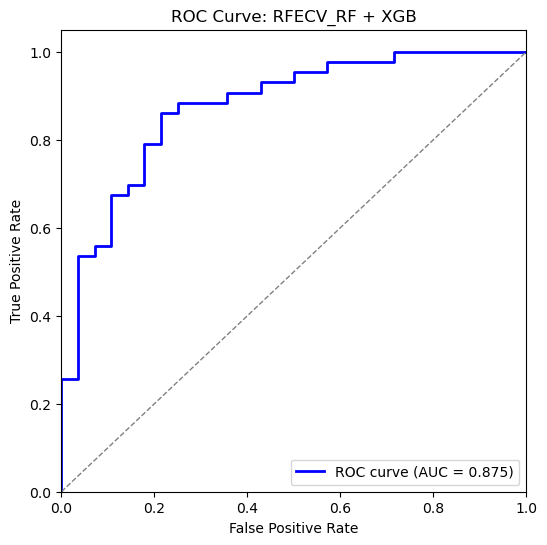

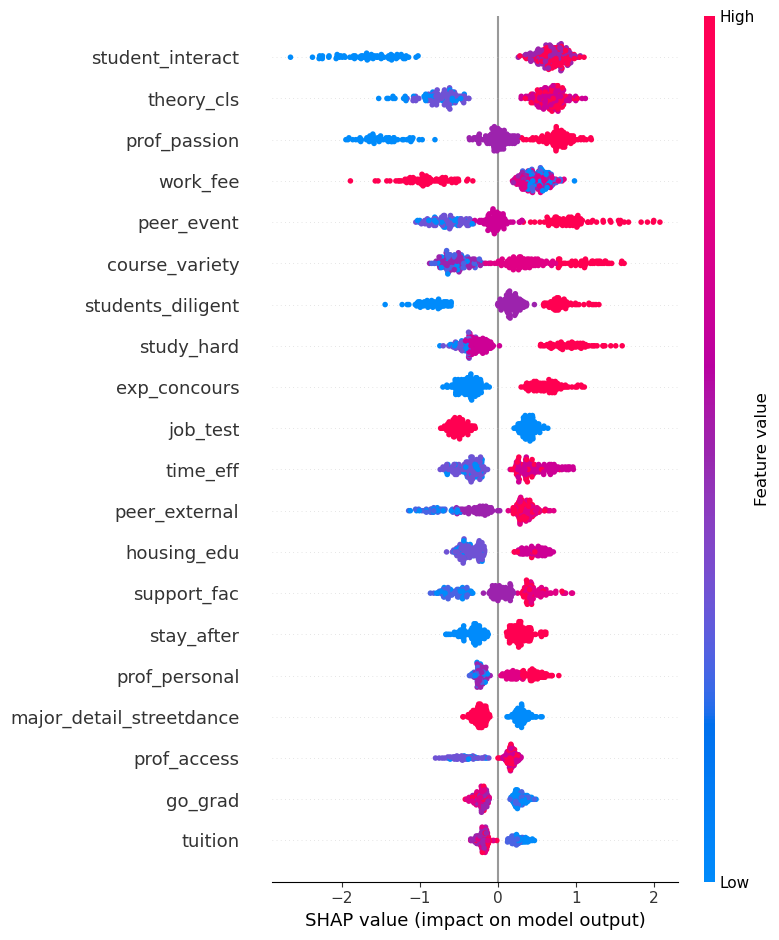

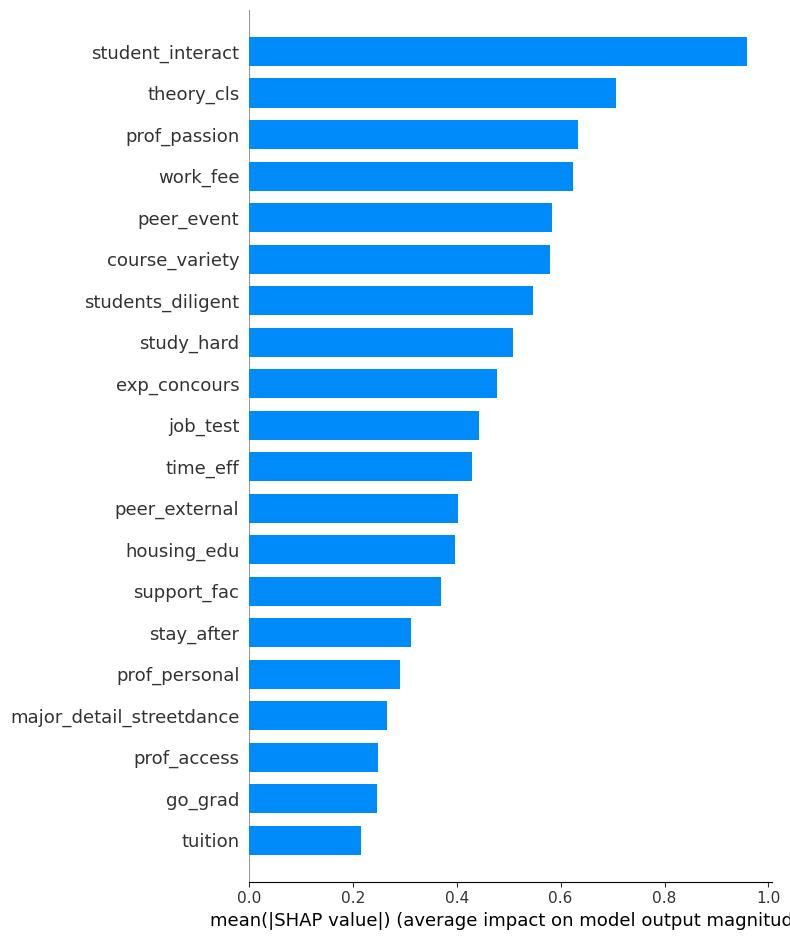

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import shap
import numpy as np

# ======================================
# 1️⃣ ROC Curve
# ======================================
y_true = y_test
y_score = fitted_pipe.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: RFECV_RF + XGB')
plt.legend(loc='lower right')
plt.show()


# ======================================
# 2️⃣ SHAP Summary Plot (dot)
# ======================================
X_train_sel = fitted_pipe.named_steps['feature_selection'].transform(X_train)
explainer = shap.TreeExplainer(fitted_pipe.named_steps['clf'])
shap_values = explainer.shap_values(X_train_sel)

# Dot plot
shap.summary_plot(shap_values, X_train_sel, 
                  feature_names=X_train.columns[fitted_pipe.named_steps['feature_selection'].support_])

# ======================================
# 3️⃣ SHAP Summary Plot (bar)
# ======================================
shap.summary_plot(shap_values, X_train_sel, 
                  feature_names=X_train.columns[fitted_pipe.named_steps['feature_selection'].support_],
                  plot_type="bar")

# 기술통계 등 EDA 

In [73]:
import pandas as pd

# 1. 데이터 합치기
df_all = X.copy()
df_all['target'] = y

# 2. 1집단과 0집단 분리
group1 = df_all[df_all['target'] == 1]
group0 = df_all[df_all['target'] == 0]

# 3. 변수별 요약 통계 계산
summary_list = []
for col in X.columns:
    summary_list.append({
        'variable': col,
        'mean_all': df_all[col].mean(),
        'std_all': df_all[col].std(),
        'n_all': df_all[col].count(),
        'mean_1': group1[col].mean(),
        'std_1': group1[col].std(),
        'n_1': group1[col].count(),
        'mean_0': group0[col].mean(),
        'std_0': group0[col].std(),
        'n_0': group0[col].count()
    })

summary_df = pd.DataFrame(summary_list)

# 소숫점 둘째자리까지 반올림
summary_df = summary_df.round(2)

display(summary_df)


,variable,mean_all,std_all,n_all,mean_1,std_1,n_1,mean_0,std_0,n_0
0,univ_rank,1.65,0.79,355,1.52,0.73,215,1.84,0.83,140
1,major_rank,1.08,0.31,355,1.07,0.28,215,1.11,0.35,140
2,know_reason,3.74,0.97,355,4.06,0.84,215,3.26,0.96,140
3,prof_exp,3.94,0.86,355,4.17,0.76,215,3.59,0.90,140
4,study_hard,3.99,0.92,355,4.24,0.80,215,3.60,0.96,140
5,time_eff,3.49,0.96,355,3.75,0.88,215,3.09,0.93,140
6,edu_doubt,3.01,1.17,355,3.07,1.19,215,2.91,1.13,140
7,learn_fun,3.96,0.89,355,4.24,0.77,215,3.53,0.88,140
8,study_mate,4.24,0.94,355,4.46,0.80,215,3.90,1.04,140
9,try_hard,3.63,0.88,355,3.85,0.80,215,3.29,0.89,140


In [104]:
# 수치형 변수 t검정 
import pandas as pd
from scipy.stats import ttest_ind

# -------------------------
# target 포함 df_all
# -------------------------
df_all = df.copy()
df_all["target"] = df_all["sat_group"]

# -------------------------
# 원핫인코딩된 컬럼 패턴 (범주형)
# -------------------------
cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

# -------------------------
# 이진형 변수
# -------------------------
bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender',
    'career_corse', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major'
]

# -------------------------
# 수치형 변수 목록 (원핫, 이진 변수 제외)
# -------------------------
numeric_vars = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_vars = [col for col in numeric_vars if col not in ["sat", "sat_group"]]
numeric_vars = [
    col for col in numeric_vars
    if not any(col.startswith(prefix + "_") for prefix in cat_prefixes)
    and col not in bin_vars
]

# -------------------------
# t-test 수행 및 p-value 등급, 집단별 mean(std) 추가
# -------------------------
ttest_results = []

for col in numeric_vars:
    group0 = df_all[df_all["target"]==0][col]
    group1 = df_all[df_all["target"]==1][col]
    
    # 독립표본 t-test (등분산 가정=False)
    t_stat, p_val = ttest_ind(group0, group1, equal_var=False, nan_policy='omit')
    
    # 유의 수준 확인
    if p_val < 0.001:
        p_level = "<0.001"
    elif p_val < 0.01:
        p_level = "<0.01"
    elif p_val < 0.05:
        p_level = "<0.05"
    else:
        continue  # p >= 0.05이면 결과에서 제외
    
    ttest_results.append({
        "variable": col,
        "t_stat": round(t_stat, 3),
        "p_value": round(p_val, 6),
        "p_level": p_level,
        "mean_group0": f"{group0.mean():.2f} ({group0.std():.2f})",
        "mean_group1": f"{group1.mean():.2f} ({group1.std():.2f})"
    })

# -------------------------
# 결과 DataFrame (p-value 기준 정렬)
# -------------------------
ttest_df = pd.DataFrame(ttest_results)
ttest_df = ttest_df.sort_values("p_value").reset_index(drop=True)

print(ttest_df)


             variable  t_stat   p_value p_level  mean_group0  mean_group1
0         support_fac  -6.062  0.000000  <0.001  2.63 (1.05)  3.36 (1.19)
1            prac_cls  -8.832  0.000000  <0.001  3.33 (0.95)  4.19 (0.82)
2          theory_cls  -9.914  0.000000  <0.001  3.12 (0.94)  4.10 (0.86)
3         prof_effort  -8.981  0.000000  <0.001  3.58 (0.87)  4.39 (0.75)
4          admin_serv  -8.065  0.000000  <0.001  3.06 (0.91)  3.87 (0.92)
5             car_spt  -8.711  0.000000  <0.001  3.03 (1.01)  3.96 (0.95)
6       intern_abroad  -6.977  0.000000  <0.001  2.84 (1.04)  3.64 (1.11)
7     prof_class_talk  -6.709  0.000000  <0.001  3.96 (0.86)  4.54 (0.69)
8     prof_other_talk  -7.297  0.000000  <0.001  3.71 (0.99)  4.43 (0.78)
9         prof_career  -8.273  0.000000  <0.001  3.19 (1.05)  4.10 (0.96)
10      prof_personal  -8.600  0.000000  <0.001  2.86 (1.15)  3.95 (1.18)
11         prof_grade  -7.392  0.000000  <0.001  3.11 (1.11)  4.00 (1.10)
12        univ_belong -18.840  0.00000

In [105]:
print("수치형 변수 개수:", len(numeric_vars))
print("수치형 변수 목록:", numeric_vars)


수치형 변수 개수: 80
수치형 변수 목록: ['id', 'univ_rank', 'major_rank', 'know_reason', 'prof_exp', 'study_hard', 'time_eff', 'edu_doubt', 'learn_fun', 'study_mate', 'try_hard', 'write_vol', 'find_data', 'self_study', 'try_fail', 'get_fdbk', 'real_appl', 'ask_q', 'fit_major', 'cont_major', 'move_univ', 'change_major', 'change_career', 'take_leave', 'drop_out', 'go_abroad', 'go_grad', 'work_fee', 'smoke_exp', 'drink_freq', 'exercise_reg', 'burnout', 'mental_health', 'physical_health', 'housing_infra', 'housing_transit', 'housing_safety', 'housing_hygiene', 'housing_green', 'housing_culture', 'housing_edu', 'housing_neighbor', 'lecture_fac', 'support_fac', 'scholarship', 'tuition', 'transport', 'prac_cls', 'theory_cls', 'prof_effort', 'admin_serv', 'car_spt', 'intern_abroad', 'career_course', 'prof_class_talk', 'prof_other_talk', 'prof_career', 'prof_personal', 'prof_grade', 'prof_event', 'peer_class', 'peer_career', 'peer_advice', 'peer_event', 'peer_external', 'students_diligent', 'course_variety', 

In [103]:
# 범주형 변수 카이검정 
import pandas as pd
from scipy.stats import chi2_contingency

df_all = df.copy()
df_all["target"] = df_all["sat_group"]

cat_prefixes = [
    'univ_factor', 'major_factor', 'job_region', 'weight_control',
    'birth_area', 'housing_type', 'enter_type',
    'major_detail', 'univ_name', 'univ_area'
]

bin_vars = [
    'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender',
    'career_corse', 'career_mentoring', 'job_test', 'job_prep',
    'field_practice', 'abroad_practice', 'job_info', 'job_fair',
    'move_for_univ', 'stay_after', 'has_future_job', 'has_income',
    'has_major_income', 'rechoice_major'
]

chi_results = []

# 함수: 교차표 + 행 기준 비율 + 전체 대비 비율 + chi2
def process_variable(var_name, df, target="target"):
    crosstab = pd.crosstab(df[var_name], df[target])
    row_pct = crosstab.div(crosstab.sum(axis=1), axis=0) * 100
    total_pct = crosstab.div(len(df)) * 100
    display_table = crosstab.astype(str) + " (" + row_pct.round(1).astype(str) + "% / " + total_pct.round(1).astype(str) + "%)"
    
    print(f"\n=== {var_name} vs 만족도 ===")
    print(display_table)
    
    if crosstab.shape[0] > 1:
        chi2, p, dof, expected = chi2_contingency(crosstab)
        print(f"\n>>> {var_name} 카이제곱 검정 결과: chi2={chi2:.3f}, df={dof}, p={p:.6f} ({'유의' if p < 0.05 else '비유의'})")
        chi_results.append({
            "variable": var_name,
            "chi2": round(chi2, 3),
            "dof": dof,
            "p_value": round(p, 6),
            "significant": "유의" if p < 0.05 else "비유의"
        })

# 범주형 변수 처리
for prefix in cat_prefixes:
    cols = [c for c in df_all.columns if c.startswith(prefix + "_")]
    if not cols:
        continue

    df_all[cols] = df_all[cols].apply(pd.to_numeric, errors="coerce").fillna(0)
    df_all[f"{prefix}_raw"] = df_all[cols].idxmax(axis=1).str.replace(prefix + "_", "")
    process_variable(f"{prefix}_raw", df_all)

# 이진형 변수 처리
for col in bin_vars:
    if col not in df_all.columns:
        continue
    process_variable(col, df_all)

# 카이제곱 요약
chi_df = pd.DataFrame(chi_results).sort_values(by="p_value").reset_index(drop=True)
print("\n=== 카이제곱 결과 요약 (p-value 기준 정렬) ===")
print(chi_df)



=== univ_factor_raw vs 만족도 ===
target                             0                   1
univ_factor_raw                                         
commute_near       13 (46.4% / 3.7%)   15 (53.6% / 4.2%)
edu_duration        5 (71.4% / 1.4%)    2 (28.6% / 0.6%)
edu_structure       5 (17.9% / 1.4%)   23 (82.1% / 6.5%)
etc                 3 (75.0% / 0.8%)    1 (25.0% / 0.3%)
grade_fit          11 (44.0% / 3.1%)   14 (56.0% / 3.9%)
in_seoul           1 (100.0% / 0.3%)     0 (0.0% / 0.0%)
job_prospects       4 (30.8% / 1.1%)    9 (69.2% / 2.5%)
low_tuition         8 (61.5% / 2.3%)    5 (38.5% / 1.4%)
major_apportunity  28 (29.5% / 7.9%)  67 (70.5% / 18.9%)
official_univ      1 (100.0% / 0.3%)     0 (0.0% / 0.0%)
parent_teacher     19 (50.0% / 5.4%)   19 (50.0% / 5.4%)
peer_advice         6 (46.2% / 1.7%)    7 (53.8% / 2.0%)
prefer_prof        14 (50.0% / 3.9%)   14 (50.0% / 3.9%)
social_reputation  20 (33.9% / 5.6%)  39 (66.1% / 11.0%)
total              2 (100.0% / 0.6%)     0 (0.0% / 0.0%)

In [106]:
# cat_prefixes 원핫 → 단일값으로 복원
categorical_vars_raw = [f"{prefix}_raw" for prefix in cat_prefixes]

# bin_vars 그대로
categorical_vars_bin = [col for col in bin_vars if col in df_all.columns]

# 전체 범주형 변수 목록
categorical_vars_all = categorical_vars_raw + categorical_vars_bin

print("범주형 변수 개수:", len(categorical_vars_all))
print("범주형 변수 목록:", categorical_vars_all)


범주형 변수 개수: 27
범주형 변수 목록: ['univ_factor_raw', 'major_factor_raw', 'job_region_raw', 'weight_control_raw', 'birth_area_raw', 'housing_type_raw', 'enter_type_raw', 'major_detail_raw', 'univ_name_raw', 'univ_area_raw', 'exp_solo_comp', 'exp_group_comp', 'exp_concours', 'gender', 'career_mentoring', 'job_test', 'job_prep', 'field_practice', 'abroad_practice', 'job_info', 'job_fair', 'move_for_univ', 'stay_after', 'has_future_job', 'has_income', 'has_major_income', 'rechoice_major']


In [67]:
# 전처리 후 최종 변수 목록
final_vars = df.columns.tolist()
print("총 변수 수:", len(final_vars))
print("변수 목록:")
for var in final_vars:
    print(var)


총 변수 수: 180
변수 목록:
id
univ_rank
major_rank
know_reason
prof_exp
study_hard
time_eff
edu_doubt
learn_fun
study_mate
try_hard
write_vol
find_data
self_study
try_fail
get_fdbk
real_appl
ask_q
fit_major
cont_major
rechoice_major
move_univ
change_major
change_career
take_leave
drop_out
go_abroad
go_grad
work_fee
has_future_job
has_income
has_major_income
smoke_exp
drink_freq
exercise_reg
burnout
mental_health
physical_health
housing_infra
housing_transit
housing_safety
housing_hygiene
housing_green
housing_culture
housing_edu
housing_neighbor
move_for_univ
stay_after
lecture_fac
support_fac
scholarship
tuition
transport
prac_cls
theory_cls
prof_effort
admin_serv
car_spt
intern_abroad
career_course
career_mentoring
job_test
job_prep
field_practice
abroad_practice
job_info
job_fair
prof_class_talk
prof_other_talk
prof_career
prof_personal
prof_grade
prof_event
peer_class
peer_career
peer_advice
peer_event
peer_external
students_diligent
course_variety
student_interact
prof_passion
prof_access

In [92]:
# 인구통계학적 변수 빈도

import pandas as pd
from scipy.stats import chi2_contingency

# 범주 복원
area_cols = [col for col in df.columns if col.startswith("univ_area_")]
df["univ_area_raw"] = df[area_cols].idxmax(axis=1).str.replace("univ_area_", "")

major_cols = [col for col in df.columns if col.startswith("major_detail_")]
df["major_detail_raw"] = df[major_cols].idxmax(axis=1).str.replace("major_detail_", "")

# 범주형 변수 목록
cat_vars = ["gender", "grade", "univ_course_year", "dance_years", "enter_type_raw","univ_area_raw", "major_detail_raw"]

# target 포함 df_all
df_all = df.copy()
df_all["target"] = df_all["sat_group"]

chi_results = []

for col in cat_vars:
    # 교차표 (빈도) + 전체 합계 포함
    crosstab_count = pd.crosstab(df_all[col], df_all["target"], margins=True, margins_name="All")

    # 전체 대비 비율 (행 기준 아님, 전체 n 기준 %)
    crosstab_pct = crosstab_count / len(df_all) * 100

    # 빈도 + 비율 결합
    combined = crosstab_count.astype(str) + " (" + crosstab_pct.round(1).astype(str) + "%)"

    print(f"\n=== {col} 분포 (빈도수 + 전체 대비 %) ===")
    print(combined)

    # 카이제곱 검정 (합계 행 제거)
    chi2, p, dof, expected = chi2_contingency(crosstab_count.iloc[:-1, :-1])
    chi_results.append({
        "variable": col,
        "chi2": round(chi2, 3),
        "dof": dof,
        "p_value": round(p, 4),
        "significant": "유의" if p < 0.05 else "비유의"
    })

# 카이제곱 결과 요약
chi_df = pd.DataFrame(chi_results)
print("\n=== 카이제곱 검정 결과 요약 ===")
print(chi_df)



=== gender 분포 (빈도수 + 전체 대비 %) ===
target            0            1           All
gender                                        
0       116 (32.7%)  170 (47.9%)   286 (80.6%)
1         24 (6.8%)   45 (12.7%)    69 (19.4%)
All     140 (39.4%)  215 (60.6%)  355 (100.0%)

=== grade 분포 (빈도수 + 전체 대비 %) ===
target            0            1           All
grade                                         
1        62 (17.5%)  114 (32.1%)   176 (49.6%)
2        45 (12.7%)   50 (14.1%)    95 (26.8%)
3         13 (3.7%)    16 (4.5%)     29 (8.2%)
4         20 (5.6%)    35 (9.9%)    55 (15.5%)
All     140 (39.4%)  215 (60.6%)  355 (100.0%)

=== univ_course_year 분포 (빈도수 + 전체 대비 %) ===
target                      0            1           All
univ_course_year                                        
2                  70 (19.7%)  102 (28.7%)   172 (48.5%)
3                    8 (2.3%)    18 (5.1%)     26 (7.3%)
4                  62 (17.5%)   95 (26.8%)   157 (44.2%)
All               140 (39.4%)  215 (6

KeyError: 'enter_type_raw'